#  <center> Problem Set 4 <center>
<center> Spring 2021 <center>
<center> 3.100/3.322, 10.402/10.602, 20.301/20.401 <center>
<center> Due:10 pm ET on Thursday, Apr 22, 2021 <center>

## Part 2 Graph Convolutional Nets 

### 1.1 Install and try out RDkit

In [ ]:
# This is a hack to install rdkit without needing to install conda which might take minutes 
# if you have anaconda installed, you can install rdkit from anaconda 
url = 'https://anaconda.org/rdkit/rdkit/2018.09.1.0/download/linux-64/rdkit-2018.09.1.0-py36h71b666b_1.tar.bz2'
!curl -L $url | tar xj lib
!mv lib/python3.6/site-packages/rdkit /usr/local/lib/python3.7/dist-packages/

x86 = '/usr/lib/x86_64-linux-gnu'
!mv lib/*.so.* $x86/
!ln -s $x86/libboost_python3-py36.so.1.65.1 $x86/libboost_python3.so.1.65.1

In [33]:
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors,Crippen
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
import sys
import torch 
from tqdm import tqdm
import itertools

from rdkit import RDLogger   
RDLogger.DisableLog('rdApp.*')

In [51]:
# mount your google drive to save model and files 

# from google.colab import drive
# dir_path = '/content/drive'
# drive.mount(dir_path)

dir_path = './'

In [2]:
### example 
# make a mol object 
dopamine_mol = Chem.MolFromSmiles("C1=CC(=C(C=C1CCN)O)O") # Dopamine 
caffeine_mol = Chem.MolFromSmiles("CN1C=NC2=C1C(=O)N(C(=O)N2C)C") # Caffeine 

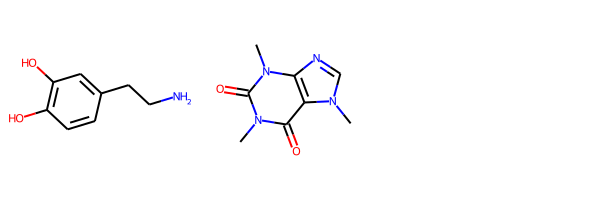

In [3]:
# Arrange molecules in a grid image
Draw.MolsToGridImage([dopamine_mol, caffeine_mol])

### 1.2 Construct Molecular Graph Datasets

In [4]:
# implement SMILES to graph function  
def smiles2graph(smiles):
    '''
    Transfrom smiles into a list nodes (atomic number)
    
    Args: 
        smiles (str): SMILES strings
    
    return: 
        z(np.array), A (np.array): list of atomic numbers, adjancency matrix 
    '''
    
    mol = Chem.MolFromSmiles( smiles ) # no hydrogen 
    z = np.array( [atom.GetAtomicNum() for atom in mol.GetAtoms()] )
    A = np.stack(Chem.GetAdjacencyMatrix(mol))
    
    return z, A

In [5]:
! wget https://raw.githubusercontent.com/wwang2/ML4MolEng/master/psets/ps4/data/qm9.csv

--2021-04-06 14:35:29--  https://raw.githubusercontent.com/wwang2/ML4MolEng/master/psets/ps4/data/qm9.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30584525 (29M) [text/plain]
Saving to: ‘qm9.csv.1’

qm9.csv.1           100%[===================>]  29.17M  69.9MB/s    in 0.4s    

2021-04-06 14:35:30 (69.9 MB/s) - ‘qm9.csv.1’ saved [30584525/30584525]



In [6]:
import torch
from sklearn.utils import shuffle

df = pd.read_csv("qm9.csv")
df = shuffle(df).reset_index()

In [7]:
z_list = []
a_list = []
y_list = []
N_list = []

for i, row in df.iterrows():
        smiles = row.smiles
        z, A = smiles2graph(smiles)          
        a = A.nonzero() 

        mol = Chem.MolFromSmiles( smiles ) 
        z_list.append(torch.LongTensor(z))
        a_list.append(torch.LongTensor(a))
        y_list.append(torch.Tensor([row.alpha]))
        N_list.append(len(z))

In [25]:
class GraphDataset(torch.utils.data.Dataset):
    def __init__(self,
                 z_list, 
                 a_list, 
                 N_list, 
                 y_list):
        
        '''
        GraphDataset object
        
        Args: 
            z_list (list of torch.LongTensor)
            a_list (list of torch.LongTensor)
            N_list (list of int)
            y_list (list of torch.FloatTensor)

        '''
        self.z_list = z_list # atomic number
        self.a_list = a_list # edge list 
        self.N_list = N_list # Number of atoms 
        self.y_list = y_list # properties to predict 

    def __len__(self):
        return len(self.N_list)

    def __getitem__(self, idx):
        
        z = torch.LongTensor(self.z_list[idx])
        a = torch.LongTensor(self.a_list[idx])
        N = self.N_list[idx]
        y = torch.Tensor(self.y_list[idx])
        
        return z, a, N, y

In [26]:
from sklearn.model_selection import train_test_split

z_train, z_test, a_train, a_test, N_train, N_test, y_train, y_test = train_test_split(z_list, 
                                                                                      a_list, 
                                                                                      N_list, 
                                                                                      y_list, test_size=0.2)

z_train, z_val, a_train, a_val, N_train, N_val, y_train, y_val = train_test_split(z_train, 
                                                                                      a_train, 
                                                                                      N_train, 
                                                                                      y_train, test_size=0.2)

In [27]:
traindataset = GraphDataset(z_train, a_train, N_train, y_train)
valdataset = GraphDataset(z_val, a_val, N_val, y_val)
testdataset =  GraphDataset(z_test, a_test, N_test, y_test)

### 1.3 Batching Molecular Graphs 

In [28]:
def collate_graphs(batch):
    '''Batch multiple graphs into one batched graph
    
    Args:
    
        batch (tuple): tuples of z, a, N and y obtained from GraphDataset.__getitem__() 
        
    Return 
        (tuple): Batched z, a, N, y
        
    Example:
    
    >>> #graph 1 
    >>> z1 = torch.LongTensor([6, 6, 7])
    >>> a1 = torch.LongTensor([[0, 2, 2, 1], [2, 0, 1, 2]])
    >>> N1 = 3
    >>> y1 =  torch.Tensor([74.18]
    >>> #graph 2 
    >>> z2 = torch.LongTensor([6, 6, 8]
    >>> a2 = torch.LongTensor([[0, 2, 2, 1], [2, 0, 1, 2]])
    >>> N2 = 3
    >>> y2 = torch.Tensor([64.32])
    
    >>> graph1 = (z1, a1, N1, y1)
    >>> graph2 = (z2, a2, N2, y2)
    
    >>> collate_graphs( (graph1, graph2) )  
    
        (tensor([6, 6, 7, 6, 6, 8]),
         tensor([[0, 2, 2, 1, 3, 5, 5, 4],
                 [2, 0, 1, 2, 5, 3, 4, 5]]),
         [3, 3],
         tensor([74.1800, 64.3200]))
    '''
    
    z_batch = []
    a_batch = []
    N_batch = []
    y_batch = []

    cumulative_atoms = np.cumsum([0] + [b[2] for b in batch])[:-1]
    
    for i in range(len(batch)):
        z, a, N, y = batch[i]
        index_shift = cumulative_atoms[i]
        a = a + index_shift
        z_batch.append(z) 
        a_batch.append(a)
        N_batch.append(N)
        y_batch.append(y)
        
    z_batch = torch.cat(z_batch)
    a_batch = torch.cat(a_batch, dim=1)
    N_batch = N_batch
    y_batch = torch.cat(y_batch)
    
    return z_batch, a_batch, N_batch, y_batch 

In [41]:
from torch.utils.data import DataLoader
train_loader = DataLoader(traindataset,
                          batch_size=512, 
                          collate_fn=collate_graphs,shuffle=True)

val_loader = DataLoader(valdataset,
                          batch_size=512, 
                          collate_fn=collate_graphs,shuffle=True)

test_loader = DataLoader(testdataset,
                          batch_size=512, 
                          collate_fn=collate_graphs,shuffle=True)

### 1.4 Implement a Graph Convolution Model

In [42]:
from torch import nn
from torch.nn import ModuleDict
from itertools import repeat

def scatter_add(src, index, dim=-1, dim_size=None, fill_value=0):
    
    index_size = list(repeat(1, src.dim()))
    index_size[dim] = src.size(dim)
    index = index.view(index_size).expand_as(src)
    
    dim = range(src.dim())[dim]
    dim_size = index.max().item() + 1 if dim_size is None else dim_size
    out_size = list(src.size())
    out_size[dim] = dim_size

    out = src.new_full(out_size, fill_value)

    return out.scatter_add_(dim, index, src)

class GNN(torch.nn.Module):
    
    def __init__(self, n_convs=3, n_embed=64):
        super(GNN, self).__init__()
        
        self.atom_embed = nn.Embedding(100, n_embed)
        self.convolutions = nn.ModuleList(
            [ 
                ModuleDict({
                    'update_mlp': nn.Sequential(nn.Linear(n_embed, n_embed), 
                                                nn.ReLU(), 
                                                nn.Linear(n_embed, n_embed)),
                    'message_mlp': nn.Sequential(nn.Linear(n_embed, n_embed), 
                                                 nn.ReLU(), 
                                                 nn.Linear(n_embed, n_embed)) 
                })
                for _ in range(n_convs)
            ]
            )
        
        self.readout = nn.Sequential(nn.Linear(n_embed, n_embed), nn.ReLU(), nn.Linear(n_embed, 1))
        
    def forward(self, z, a, N):
        
        h = self.atom_embed(z)
        
        for conv in self.convolutions:
            msg = conv['message_mlp'](h[a[0]] * h[a[1]])
            dh = conv['update_mlp'](scatter_add(msg, a[0], dim=0, dim_size=h.shape[0]))
            h += dh 
        
        # node wise output 
        node_out = self.readout( h )
        
        # split nodes back to graphs 
        node_splits = torch.split(node_out, N)
        output = torch.stack([i.sum() for i in node_splits])
            
        return output

### 1.5 Graph Convolution Operation preserves Permutation Invariances

In [43]:
def permute_graph(z, a, perm):
    z = np.array(z)
    perm = np.array(perm)
    assert len(perm) == len(z)
    
    z_perm = z[perm]
    a_perm = np.zeros(a.shape).astype(int)
    
    for i, edge in enumerate(a):
        for j in range(len(edge)):
            a_perm[i, j] = np.where(perm==edge[j])[0] #perm[edge[j]]
    return z_perm, a_perm

# permutate node ordering 
order = [0, 1 ,2]
# node input
z_orig = np.array([6, 1, 8])
# edge input 
a_orig = np.array( [[0, 0, 1, 2], [1, 2, 0, 0]] )
permutate = itertools.permutations(order)

device = 0
model = GNN(n_convs=4, n_embed=128).to(device)
model.eval()

for perm in [[0, 1, 2], [2, 0, 1], [1, 2, 0]]:
    z_perm, a_perm = permute_graph(z_orig, a_orig, perm)
    
    z = torch.LongTensor(z_perm).to(device)
    a = torch.LongTensor(a_perm).to(device)
    N = [3]

    print(model(z, a, N).item())

-1.1362228393554688
-1.1362228393554688
-1.1362228393554688


### 1.6 Train/Test your Graph Neural Net

In [44]:
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=50, verbose=True)

In [52]:
# Implement Tqdm 

def loop(model, loader, epoch, evaluation=False):
    
    if evaluation:
        model.eval()
        mode = "eval"
    else:
        model.train()
        mode = 'train'
    batch_losses = []
        
    tqdm_data = tqdm(loader, desc='{} (epoch #{})'.format(mode, epoch))
    
    for data in tqdm_data:
        
        z, a, N, y = batch 
        z = z.to(device)
        a = a.to(device)
        y = y.to(device)
        pred = model(z, a, N)
        loss = (pred-y).pow(2).mean()  
        
        if not evaluation:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        batch_losses.append(loss.item())

        postfix = ['batch loss={:.3f}'.format(loss.item()) , 
                   'avg. loss={:.3f}'.format(np.array(batch_losses).mean())]
        
        tqdm_data.set_postfix_str(' '.join(postfix))
    
    return np.array(batch_losses).mean()

In [53]:
for epoch in range(1000):    
    train_loss = loop(model, train_loader, epoch)
    val_loss = loop(model, val_loader, epoch, evaluation=True)
    
    if epoch % 5 == 0:
        torch.save(model.state_dict(), "{}/gcn_model_{}.pt".format(dir_path, epoch))
    # save model 

train (epoch #1):  70%|███████   | 118/168 [00:08<00:03, 13.61it/s, batch loss=3.447 avg. loss=3.600]


KeyboardInterrupt: 

In [248]:
test_loader = DataLoader(testdataset, batch_size=256, collate_fn=collate_graphs)

test_pred_list = []
test_label_list = []

model.eval()
for batch in test_loader: 
    
    z, a, N, y = batch 
    z = z.to(device)
    a = a.to(device)
    y = y.to(device)

    pred = model(z, a, N)
    test_pred_list+=pred.detach().cpu().numpy().tolist()
    test_label_list+=y.detach().cpu().numpy().tolist()

train_pred_list = []
train_label_list = []


for batch in train_loader: 
    
    z, a, N, y = batch 
    z = z.to(device)
    a = a.to(device)
    y = y.to(device)
    
    pred = model(z, a, N)

    train_pred_list+=pred.detach().cpu().numpy().tolist()
    train_label_list+=y.detach().cpu().numpy().tolist()

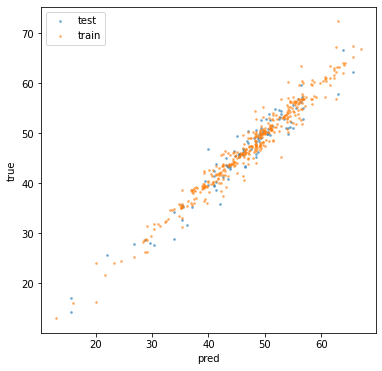

In [249]:
import matplotlib.pyplot as plt


plt.figure(figsize=(6,6))
plt.scatter(test_pred_list, test_label_list, s=3, alpha=0.5, label='test')
plt.scatter(train_pred_list, train_label_list, s=3 , alpha=0.5, label='train')
plt.ylabel("true")
plt.xlabel("pred")
plt.legend()